# Regression Refresher Exercises

In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib.lines import Line2D
from matplotlib.patches import  FancyArrowPatch

In [2]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

In [3]:
data = pd.read_csv("data/fish-market.csv")
data = data[data["Weight"] > 0].reset_index(drop=True)

## Exercise 1: Create a basic linear regression model

You're asked to build a linear regression model to predict the weight of the fish based on their width. Take the following points into consideration while building your model.

* Are transformations needed? Does it make sense to... 
    * Transform the predictor?
    * Transform the response?
    * Both?
* How many lines of code is it?

In addition, this is the opportunity to be creative. You can try other transformations and custom visualizations as well. 

Have fun!

Let's have a look at the relationship between Width and Weight in the untransformed scale. Here we want to verify if a staright line is going to be a good approximation.

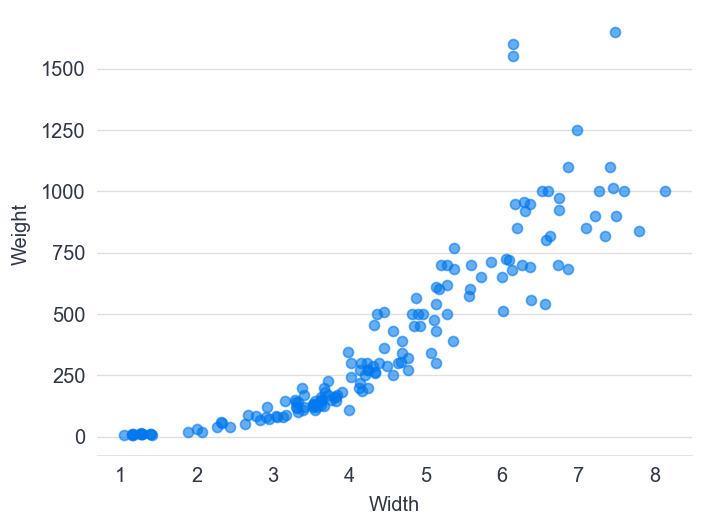

In [4]:
fig, ax = plt.subplots()
ax.scatter(data["Width"], data["Weight"], alpha=0.6);
ax.set(xlabel="Width", ylabel="Weight");

Definitely, the relationship is non-linear. A straight line in the untransformed space is not going to work very well.

Let's try again with the same log transformation we used in the lesson. 

We create a visualization with several panels because we show the different combinations of the transformations.

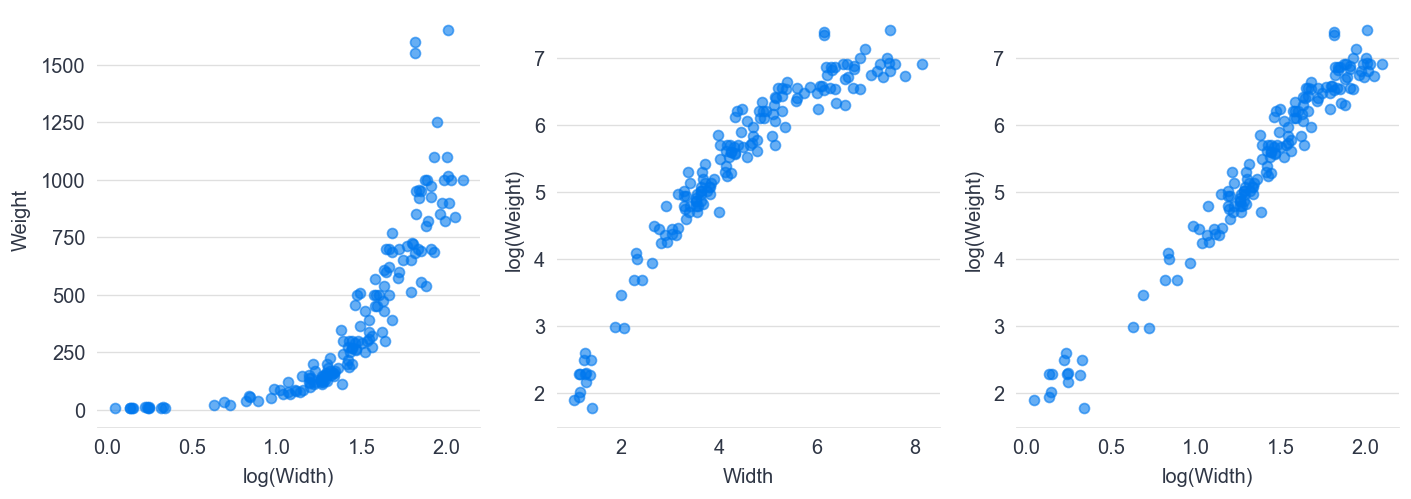

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4.5))

axes[0].scatter(np.log(data["Width"]), data["Weight"], alpha=0.6)
axes[0].set(xlabel="log(Width)", ylabel="Weight");

axes[1].scatter(data["Width"], np.log(data["Weight"]), alpha=0.6)
axes[1].set(xlabel="Width", ylabel="log(Weight)")

axes[2].scatter(np.log(data["Width"]), np.log(data["Weight"]), alpha=0.6)
axes[2].set(xlabel="log(Width)", ylabel="log(Weight)");

In [6]:
log_width = np.log(data["Width"])
log_weight = np.log(data["Weight"])

with pm.Model() as model:
    β0 = pm.Normal("β0", mu=0, sigma=5)
    β1 = pm.Normal("β1", mu=0, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=5)
    mu = β0 + β1 * log_width
    pm.Normal("weight", mu=mu, sigma=sigma, observed=log_weight)
    idata = pm.sample(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β0, β1, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


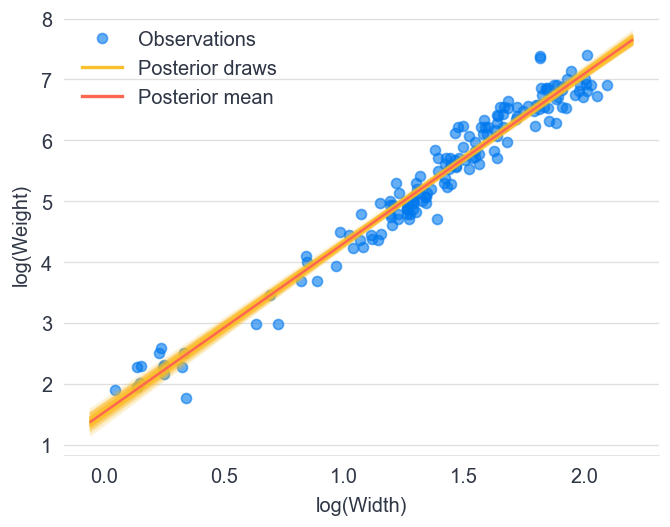

In [7]:
b0_draws = idata.posterior["β0"][:, ::10].to_numpy().flatten()
b1_draws = idata.posterior["β1"][:, ::10].to_numpy().flatten()

fig, ax = plt.subplots()
ax.scatter(log_width, log_weight, alpha=0.6)
ax.set(xlabel="log(Width)", ylabel="log(Weight)")

x_grid = np.array(ax.get_xlim())
for b0, b1 in zip(b0_draws, b1_draws):
    ax.plot(x_grid, b0 + b1 * x_grid, color="C1", alpha=0.1)

b0_mean = b0_draws.mean().item()
b1_mean = b1_draws.mean().item()
ax.plot(x_grid, b0_mean + b1_mean * x_grid, color="C4")

handles = [
    Line2D([], [], label="Observations", lw=0, marker="o", color="C0", alpha=0.6),
    Line2D([], [], label="Posterior draws", lw=2, color="C1"),
    Line2D([], [], label="Posterior mean", lw=2, color="C4"),
]
ax.legend(handles=handles, loc="upper left");

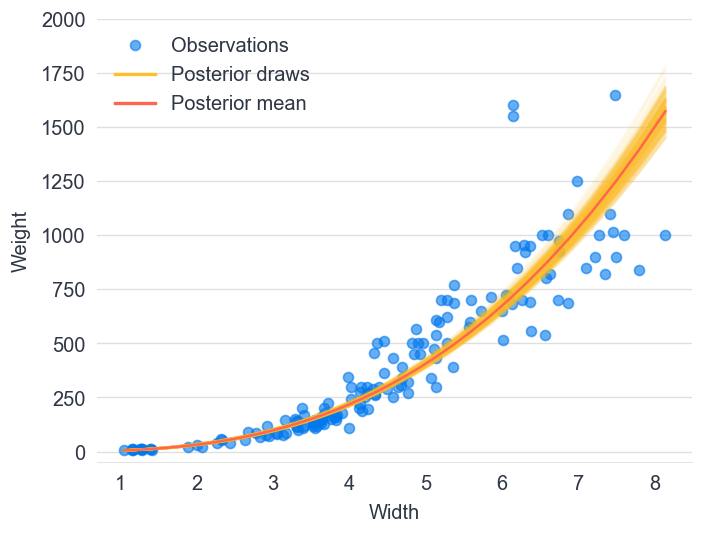

In [8]:
b0_draws = idata.posterior["β0"][:, ::10].to_numpy().flatten()
b1_draws = idata.posterior["β1"][:, ::10].to_numpy().flatten()

fig, ax = plt.subplots()
ax.scatter(data["Width"], data["Weight"], alpha=0.6)
ax.set(xlabel="Width", ylabel="Weight", ylim=(-50, 2000))

x_grid = np.linspace(log_width.min(), log_width.max())
for b0, b1 in zip(b0_draws, b1_draws):
    ax.plot(np.exp(x_grid), np.exp(b0 + b1 * x_grid), color="C1", alpha=0.1)

b0_mean = b0_draws.mean().item()
b1_mean = b1_draws.mean().item()
ax.plot(np.exp(x_grid), np.exp(b0_mean + b1_mean * x_grid), color="C4")

handles = [
    Line2D([], [], label="Observations", lw=0, marker="o", color="C0", alpha=0.6),
    Line2D([], [], label="Posterior draws", lw=2, color="C1"),
    Line2D([], [], label="Posterior mean", lw=2, color="C4"),
]
ax.legend(handles=handles, loc="upper left");

The line fit is better than the one in the model we developed in "Section 60: Transformations". We see the line does not show any systematic underestimation or overestimation. That's awesome!

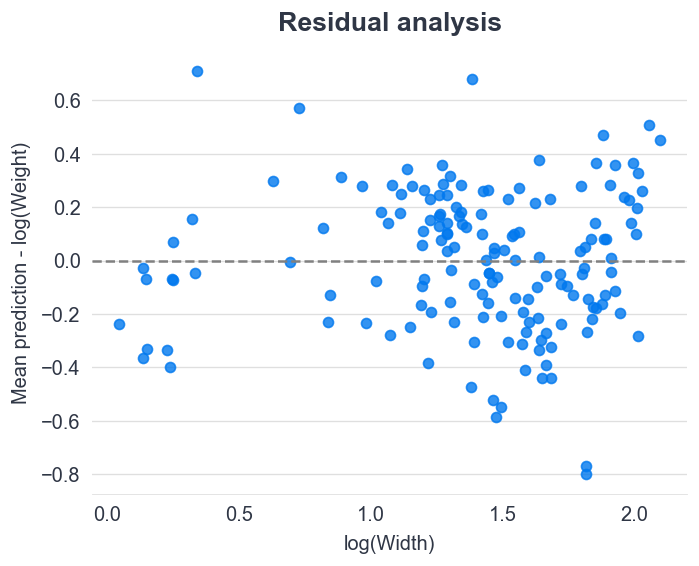

In [9]:
log_y_hat = b0_mean + b1_mean * log_width
log_residuals = log_y_hat - log_weight

fig, ax = plt.subplots()
ax.scatter(log_width, log_residuals, alpha=0.8);
ax.axhline(0, ls="--", color="0.5")
ax.set(
    xlabel="log(Width)", 
    ylabel="Mean prediction - log(Weight)", 
    title="Residual analysis"
);

The goodness we see in the curve fit is show here as well. There are no clear deviations from a random pattern anymore.

If we could only have used a single predictor, using Width looks more promising that Length!

## Exercise 2: What if we only use the species of fish?

In the lesson, we included the species variable as predictor in a model that already had a numerical predictor.

However, we didn't cover how a model that includes the species, but not the length, would look like. That's what this exercise is about!

You have to create a linear regression model using only the species of fish as predictor. Answer the following questions:

* Is there a slope parameter? 
* How many intercept parameters does the model have? Is it one, or more than one? Why?
* What is the meaning of the intercept parameter(s)?
* Is it necessary to transform the response variable?
* What's the difference between this model and the intercept-only model?

Finally, create a plot to show the regression line(s).

## Exercise 3: Multiple intercepts, but a single slope

The model we created in "Section 70: Accounting for species" considers varying intercepts and slopes for every species. It is, every species had its own intercept and its own slope. We did this because we mentioned it was the most flexible approach. However, when we analyzed the posterior estimates we noticed the slope posteriors were all quite similar, meaning regression lines for the species were indeed parallel. Because of this, it makes sense to have a single slope parameter instead of multiple ones, which reduces the complexity of the model a little.

The goal of this exercise is to write a regression model with unpooled intercepts, one intercept per species, but a completely pooled slope -- a single, common, slope for all species. Consider the following points when solving the exercise

* Perform the same train-test split than in "Section 80: New fish arrive". 
* Build the model with a single slope, but multiple intercepts, using the train dataset.
* Predict the weight of the fish in the test set.
* Compare the predictions obtained here with the ones obtained in "Section 80: New fish arrive"

Also, do you notice any difference in sampling speed? Why? Is that what you were expecting?

**COMMENT:** I think we can include the loading of the data and the train-test split so we make sure it's clear we need to use the same seed so results are comparable with the ontes obatined in Section 80.

## Exercise 4: Test your skills with a brand new problem!

You work in the civil engineering department of a major university. You are part of a project testing the strength of concrete samples.

Concrete is the most widely used building material in the world. It is a mix of cement and water with gravel and sand. It can also include other materials like fly ash, blast furnace slag, and additives.

The compressive strength of concrete is a function of components and age, so your team is testing different combinations of ingredients at different time intervals.

The project leader asked you to find a simple way to estimate strength so that students can predict how a particular sample is expected to perform.

### The data

The team has already tested more than a thousand samples ([source](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength))

This is a description of the variables

* **cement** - Portland cement in kg/m3
* **slag** - Blast furnace slag in kg/m3
* **fly_ash** - Fly ash in kg/m3
* **water** - Water in liters/m3
* **superplasticizer** - Superplasticizer additive in kg/m3
* **coarse_aggregate** - Coarse aggregate (gravel) in kg/m3
* **fine_aggregate** - Fine aggregate (sand) in kg/m3
* **age** - Age of the sample in days
* **strength** - Concrete compressive strength in megapascals (MPa)

### The challenge

Provide your project leader with a formula that estimates the compressive strength. Include:

* The coefficients $\beta_0, \cdots, \beta_8$ to use in the following formula:

$$
\text{Concrete Strenght} = \beta_0  + \beta_1 \text{cement} + \beta_2 \text{slag} + \beta_3 \text{fly ash} + \beta_4 \text{water} + \beta_5 \text{superplasticizer} + \beta_6 \text{coarse aggregate} + \beta_7 \text{fine aggregate} + \beta_8 \text{age}
$$

* The average strength of the concrete samples at 1, 7, 14, and 28 days of age.

**TODO** Cite the paper where we take data from. It's required by the authors.